# Stochastic Simulation for the Reputation Score

Reference: https://hackmd.io/8CSLDfKNSAyyl-OfEzOdDQ

## Depedences

In [11]:
import scipy.stats as st
from dataclasses import dataclass
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from tqdm.auto import tqdm
from copy import deepcopy
import xarray as xr
import pandas as pd

## Definitions

In [12]:
from signal import signal
from regex import R


Filecoin = float
Days = float

def float_power(number: float,
                   power: float) -> float:
    return np.sign(number) * (np.abs(number) ** power)

@dataclass
class Deal():
    """
    State container for Deals.
    """

    payment: Filecoin 
    collateral: Filecoin
    duration: Days
    start: Days
    slash_date: Days = 0
    will_slash: bool = False # true if deal will be slashed eventually, false otherwise
    finished: bool = False
    slashed: bool = False
    is_early: bool = False

    @property
    def F(self):
        return 1.0 if self.finished else 0.0
    
    def set_date(self,
                 chance_slash: float):
        self.will_slash = st.bernoulli(chance_slash).rvs() # decides if the deal will be slashed
        if self.will_slash:
            self.slash_date = st.randint.rvs(1,self.duration+1) # if we decide so, we choose the date with uniform probability within the duration of the deal
        else:
            self.slash_date = 0 # if not, we choose a date outside the duration of the deal (probably unecessary)

    def payoff_1(self,
                 slash_penalty: float) -> float:
        """
        Deal Payoff associated with the "Skin in the Game" reputation.
        
            payoff_1 = duration * (penalty | collateral), if deal is finished
            payoff_1 = duration * (penalty | collateral) * ongoing, if the deal is ongoing
        """
        payoff = self.duration
        
        if self.slashed:
            payoff *= slash_penalty
        else:
            payoff *= self.collateral
            # Active deals only
            payoff *= 1.0 if self.finished else 0.1 # test with 0.0
        return payoff 

    def payoff_2(self,
                 slash_penalty: float,
                 early_multiplier: float) -> float:
        """
        Deal Payoff associated with the Capacity reputation.
        
            payoff_2 = duration * (penalty | collateral/payment) * (1 | 1 + early_multiplier)
        """
        payoff = self.duration
        if self.slashed:
            payoff *= slash_penalty
        else:
            payoff *= self.collateral
            # Finished deals only
            payoff *= 1.0 if self.finished else 0.0
            payoff /= self.payment
            payoff *= (1+(early_multiplier if self.is_early else 0.0)) # is that right?
            # no ongoing payoff, is that right?
        return payoff 


@dataclass
class Provider():
    """

    """
    deals: list[Deal]
    #pslashed: bool = False #only for test
    finished_deals: int = 0

    def payoff_1(self,
                 slash_penalty: float,
                 alpha: float) -> float:
        """
        Provider Payoff associated with the "Skin in the Game" reputation.
        """

        return sum(float_power(d.payoff_1(slash_penalty),alpha)
                   for d
                   in self.deals)

    def payoff_2(self,
                 slash_penalty: float,
                 alpha: float,
                 early_multiplier: float) -> float:
        """
        Provider Payoff associated with the Capacity reputation.
        """
        
        return sum(float_power(d.payoff_2(slash_penalty, early_multiplier), alpha) # payoff can be negative, so be careful here 
                   for d
                   in self.deals)


@dataclass
class ReputationSystemState():
    """

    """
    providers: list[Provider]
    slash_penalty_1: float = -10
    alpha_1: float = 1.0
    slash_penalty_2: float = -10
    alpha_2: float = 0.5
    early_multiplier: float = 0.01

    def rate_score(self,
                   score: float) -> float:

        if score < 0:
            return None
        elif score < 20:
            return 1 + score * (1 / 20)
        elif score < 50:
            return 2 + (score - 20) * (1 / 30)
        elif score < 80:
            return 3 + (score - 50) * (1 / 30)
        elif score < 95:
            return 4 + (score - 80) * (1 / 30)
        elif score <= 100:
            return 4.5 + (score - 95) * (1 / 10)
        else:
            return None
            

    def rate_scores(self,
                    norm_scores: list[float]) -> list[float]:
        """
        Map a list of ranking-percentile numbers to an [1, 5] rule-based range.
        """
        return [self.rate_score(s) for s in norm_scores]

    def normalize_provider_payoffs(self,
                                   payoffs: list[float]) -> list[float]:
        """
        Normalize an list of payoffs to ranking-percentile, between 0 and 100.
        """
        if len(payoffs) > 0:
            provider_ranking = rankdata(payoffs)
            provider_norm_ranking = 100 * provider_ranking / max(provider_ranking)
            return provider_norm_ranking
        else:
            return []

    def payoffs_1(self) -> list[float]:
        provider_payoffs = [p.payoff_1(slash_penalty=self.slash_penalty_1,
                                       alpha=self.alpha_1)
                            for p
                            in self.providers]
        return provider_payoffs

    def payoffs_2(self) -> list[float]:
        provider_payoffs = [p.payoff_2(slash_penalty=self.slash_penalty_2,
                                       alpha=self.alpha_2,
                                       early_multiplier=self.early_multiplier)
                            for p
                            in self.providers]
        return provider_payoffs


## Simulations

In [13]:
initial_system = ReputationSystemState(providers=[],
                                       slash_penalty_1=-10000,
                                       alpha_1=1.0,
                                       slash_penalty_2=-1000000,
                                       alpha_2=0.5,
                                       early_multiplier=0.001)

TIMESTEPS: Days = 200
MC_RUNS: int = 1

from random import random
from scipy.stats import poisson, randint, multivariate_normal
NEW_PROVIDER_PROCESS = poisson(1.0)
NEW_DEAL_PROCESS = poisson(1.0)
NEW_DEAL_DURATION = randint(low=2, high=40)
NEW_PAYMENT = lambda duration: duration * 0.05
CHANCE_SLASH = 0.01

runs = []
for run in tqdm(range(MC_RUNS), desc='Run'):
    system_over_time = {0: initial_system}
    system = deepcopy(initial_system)
    for t in tqdm(range(TIMESTEPS), desc='Simulating Deals'):
        # For each timestep:
        # T1. Decide if there are new providers to be added.
        # T2. Iterate on each provider.

        providers = system.providers

        # (T1)
        providers_to_add_count = 0
        if len(providers) == 0:
            providers_to_add_count += 3
            is_early = True
        else:
            providers_to_add_count += NEW_PROVIDER_PROCESS.rvs()
            is_early = False

        new_providers = []
        for _ in range(providers_to_add_count):
            new_deals_count = NEW_DEAL_PROCESS.rvs()
            deals = []
            for _ in range(new_deals_count):
                duration = NEW_DEAL_DURATION.rvs()
                payment = duration * 0.05 # TODO: parametrize # go back to 0.1 random() later
                collateral = payment * (1 + 100 * random()) # TODO: parametrize
                deal = Deal(payment=payment,
                            collateral=collateral,
                            duration=duration,
                            start=t,
                            is_early=is_early)
                
                deal.set_date(chance_slash=CHANCE_SLASH)
                deals.append(deal)
            p = Provider(deals)
            new_providers.append(p)

        # (T2)
        for provider in system.providers:
            # For each provider:
            # P1. Mark as `finished` any applicable deals.
            # P2. Decide if there are existing deals to be slashed.
            # P3. Decide if there are new deals to be added.
            for deal in provider.deals:
                # (P1)
                if (deal.start + deal.duration + 1) == t :
                    deal.finished = True
                    provider.finished_deals+=1
                # (P2)
                elif ((deal.start + deal.slash_date) == t): #and (not provider.pslashed) #only for test
                    deal.slashed = True
                    #provider.pslashed = True #only for test

            # (P3)
            new_deals_count = NEW_DEAL_PROCESS.rvs()
            for _ in range(new_deals_count):
                duration = NEW_DEAL_DURATION.rvs()
                payment = duration * 0.05 # TODO: parametrize
                collateral = payment * (1 + 100 * random()) # TODO: parametrize
                d = Deal(payment=payment,
                        collateral=collateral,
                        duration=duration,
                        start=t)
                d.set_date(chance_slash=CHANCE_SLASH)
                provider.deals.append(d)

        system.providers = system.providers + new_providers
        system_over_time[t + 1] = deepcopy(system)
    runs.append(deepcopy(system_over_time))


Run:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating Deals:   0%|          | 0/200 [00:00<?, ?it/s]

## Post-Processsing

In [14]:
system_records = []
provider_records = []
deal_records = []


for r, run in tqdm(enumerate(runs)):
    system_over_time = run
    for t, system in tqdm(system_over_time.items()):
        meta_record = {'run': r,
                       'timestep': t}
        reduced_system = {k: v
                          for k, v in system.__dict__.items()
                          if k != 'providers'}
        system_records.append({**meta_record,
                               **reduced_system})

        provider_payoffs_1 = system.payoffs_1()
        provider_payoffs_2 = system.payoffs_2()
        provider_scores_1 = system.normalize_provider_payoffs(
            provider_payoffs_1)
        provider_scores_2 = system.normalize_provider_payoffs(
            provider_payoffs_2)
        provider_ratings_1 = system.rate_scores(provider_scores_1)
        provider_ratings_2 = system.rate_scores(provider_scores_2)

        for p, provider in enumerate(system.providers):
            meta_record = {'run': r,
                           'timestep': t,
                           'provider': p}
            reduced_provider = {k: v
                                for k, v in provider.__dict__.items()
                                if k != 'deals'}
            reduced_provider = {**reduced_provider,
                                'provider_payoff_1': provider_payoffs_1[p],
                                'provider_payoff_2': provider_payoffs_2[p],
                                'score_1': provider_scores_1[p],
                                'score_2': provider_scores_2[p],
                                'rating_1': provider_ratings_1[p],
                                'rating_2': provider_ratings_2[p]
                                }

            provider_records.append({**meta_record,
                                    **reduced_provider})

            for d, deal in enumerate(provider.deals):
                meta_record = {'run': r,
                               'timestep': t,
                               'provider': p,
                               'deal': d}

                deal_payoff = {
                    'deal_payoff_1': deal.payoff_1(system.slash_penalty_1),
                    'deal_payoff_2': deal.payoff_2(system.slash_penalty_2,
                                                   system.early_multiplier)
                }
                deal_records.append({**meta_record,
                                    **deal.__dict__.copy(),
                                    **deal_payoff})

index_cols = ['run', 'timestep']
df_1 = pd.DataFrame(system_records).set_index(index_cols)
index_cols.append('provider')
df_2 = pd.DataFrame(provider_records).set_index(index_cols)
index_cols.append('deal')
df_3 = pd.DataFrame(deal_records).set_index(index_cols)

ds_1 = xr.Dataset.from_dataframe(df_1)
ds_2 = xr.Dataset.from_dataframe(df_2)
ds_3 = xr.Dataset.from_dataframe(df_3)
ds = xr.merge([ds_1, ds_2, ds_3])


0it [00:00, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

## Analysis

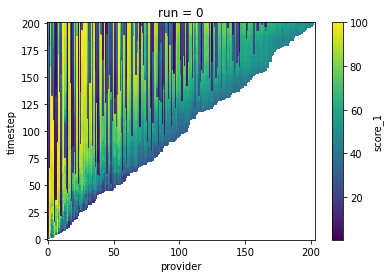

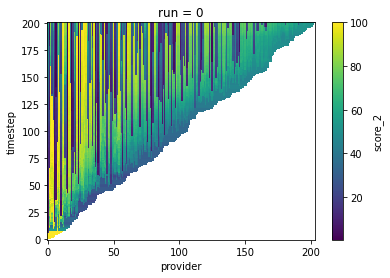

In [15]:
ds.score_1.sel(run=0).plot()
plt.show()

ds.score_2.sel(run=0).plot()
plt.show()

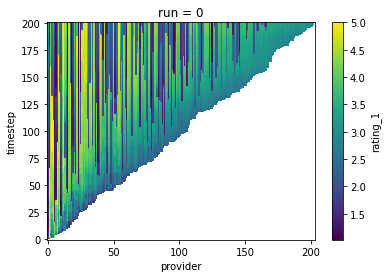

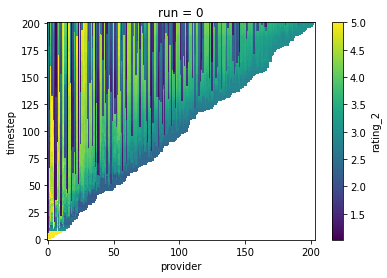

In [16]:
ds.rating_1.sel(run=0).plot()
plt.show()

ds.rating_2.sel(run=0).plot()
plt.show()

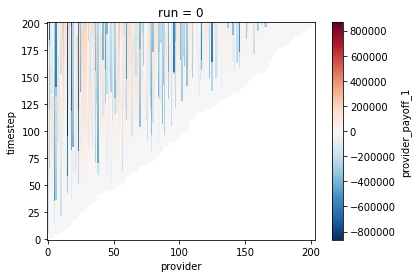

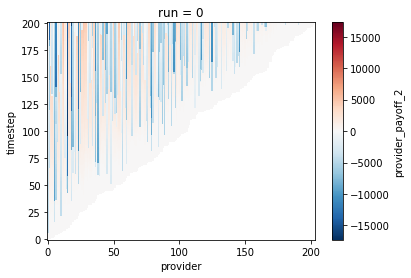

In [17]:
ds.provider_payoff_1.sel(run=0).plot()
plt.show()

ds.provider_payoff_2.sel(run=0).plot()
plt.show()

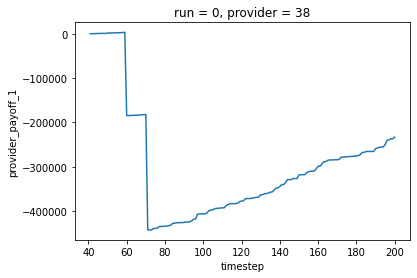

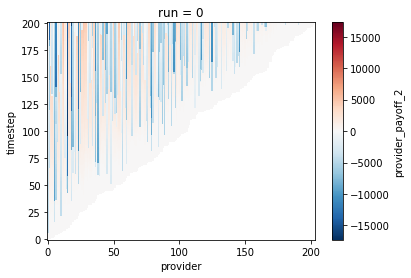

In [18]:
ds.provider_payoff_1.sel(run=0, provider = 38).plot()
plt.show()

ds.provider_payoff_2.sel(run=0).plot() # error because rating = sum (rating_deal^0.5) over deals which results in a complex number
plt.show()

In [27]:
run_providers_slash_date = []
for r in range(MC_RUNS):    
    providers_slash_date = []   
    for p in range(TIMESTEPS):
        provider_slash_date = []
        is_slashed = ds.slashed.sel(run=r, provider=p, timestep=TIMESTEPS).values
        deal_starts = ds.start.sel(run=r, provider=p, timestep=TIMESTEPS).values
        slash_dates = ds.slash_date.sel(run=r, provider=p, timestep=TIMESTEPS).values
        
        for d in range(len(is_slashed)):
            if(is_slashed[d]):
                slash_date = deal_starts[d] + slash_dates[d]
                if slash_date > 0: 
                    providers_slash_date.append([p,int(slash_date)])
                    break
                
    run_providers_slash_date.append([r,providers_slash_date])
print(run_providers_slash_date)
    

[[0, [[0, 5], [1, 65], [2, 160], [3, 134], [4, 110], [5, 35], [6, 36], [7, 89], [8, 170], [9, 136], [10, 21], [13, 75], [14, 46], [15, 42], [17, 144], [18, 35], [19, 61], [20, 80], [21, 60], [22, 187], [23, 51], [25, 88], [26, 193], [30, 111], [31, 84], [32, 144], [33, 147], [34, 86], [36, 66], [37, 125], [38, 59], [39, 58], [40, 189], [41, 188], [42, 113], [44, 125], [45, 60], [46, 138], [47, 151], [48, 51], [49, 109], [51, 115], [52, 103], [53, 133], [55, 137], [56, 98], [57, 63], [58, 188], [59, 121], [60, 69], [64, 95], [65, 187], [67, 151], [68, 172], [70, 103], [71, 197], [72, 190], [73, 161], [74, 147], [75, 109], [76, 89], [78, 121], [79, 81], [80, 107], [83, 131], [84, 85], [85, 128], [86, 126], [87, 106], [88, 142], [89, 96], [90, 190], [91, 187], [92, 129], [93, 179], [94, 104], [95, 156], [96, 152], [97, 121], [101, 165], [102, 127], [103, 169], [104, 160], [106, 141], [107, 163], [110, 149], [112, 121], [115, 132], [116, 145], [117, 156], [118, 153], [123, 149], [125, 137]

In [26]:
for [r,providers_slash_date] in run_providers_slash_date:
    times_1 = []
    times_2 = []
    
    for [p,slash_date] in providers_slash_date:
        #ds.provider_payoff_1.sel(run=r, provider=p).plot()
        
        y_1 = ds.provider_payoff_1.sel(run=r, provider=p, timestep=slash_date).values
        y_2 = ds.provider_payoff_2.sel(run=r, provider=p, timestep=slash_date).values
        #plt.axhline(y = y_1, color = 'r', linestyle = '-')
        
        payoffs_1 = ds.provider_payoff_1.sel(run=r, provider=p).values
        payoffs_2 = ds.provider_payoff_2.sel(run=r, provider=p).values
        
        for k in range(slash_date,len(payoffs_1)):
            # find timestep when provider recover from a slash or end of data
            if payoffs_1[k] > y_1 or k == len(payoffs_1)-1:
                # record difference in timesteps and in finished deals
                times_1.append([k-slash_date,ds.finished_deals.sel(run=r, provider=p, timestep=k).values-ds.finished_deals.sel(run = r, provider=p, timestep=slash_date).values])
                break
            
        for k in range(slash_date,len(payoffs_2)):
            if payoffs_2[k] > y_2 or k == len(payoffs_2)-1:
                times_2.append([k-slash_date,ds.finished_deals.sel(run=r, provider=p, timestep=k).values-ds.finished_deals.sel(run = r, provider=p, timestep=slash_date).values])
                break
            
        #plt.show()
    #plt.close()
    
    average_times_1 = np.array([0.0,0.0])
    average_times_2 = np.array([0.0,0.0])
    
    for t in times_1:
        average_times_1 += np.array(t)/len(times_1)
    for t in times_2:
        average_times_2 += np.array(t)/len(times_2)
        
    print(average_times_1)
    print(average_times_2)
    print('')

[65.33913043 64.20869565]
[68.84347826 67.72173913]

